### CISC 614 - Final Project: Stockmarket simulation
#### Roman Moser

#### 1. Define all classes and methods

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import string
import sys
import time
import scipy.stats as stats
from enum import Enum
from itertools import combinations

In [2]:
# ---------- Class for traders ---------- #
class Order(Enum):
    BUY = 1
    SELL = 2
    HOLD = 3

class Trader():
    def __init__(self, ind, cash, num_stocks, tendency=None):
        self.ind = ind
        self.cash = cash
        self.num_stocks = num_stocks
        self.tendency = tendency
        self.cluster = None
        self.order = None
        self.price = None
        self.num_stocks_trade = None
        self.cluster_action = False
        self.create_rnd_cluster()
    
    def create_rnd_cluster(self, l_=5):
        pool = string.ascii_letters + string.digits
        self.cluster = ''.join(random.choice(pool) for i in range(l_))
    
    def buy_sell_hold(self, p_buy, p_sell):
        ind = np.random.rand()
        if self.cluster_action:
            return
        else:
            if ind < p_buy:
                self.order = Order(1)
            elif ind < p_buy + p_sell:
                self.order = Order(2)
            else:
                self.order = Order(3)

    def maintain_order(self, price, expected_percentage=5):
        price_change = 0.01 * random.expovariate(1/expected_percentage) * price
        if self.order == Order.BUY:
            self.price = price * 1.05 - price_change
        if self.order == Order.SELL:
            self.price = price * 0.95 + price_change

    def amount(self, price):
        if self.cluster_action:
            return
        else:
            if self.order == Order.BUY:
                self.num_stocks_trade = np.round(random.uniform(0, 0.9 * self.cash) / price)
            if self.order == Order.SELL:
                self.num_stocks_trade = random.randint(0, np.round(0.9 * self.num_stocks))
    
    def fill_orders(self, clearing_price):
        if self.order == Order.SELL:
            if self.price <= clearing_price:
                self.cash += clearing_price * self.num_stocks_trade
                self.num_stocks -= self.num_stocks_trade
        if self.order == Order.BUY:
            if self.price >= clearing_price:
                self.cash -= clearing_price * self.num_stocks_trade
                self.num_stocks += self.num_stocks_trade

In [18]:
# ---------- Methods for demand and supply curves ---------- #
def get_buy_sell_dfs(traders):
    """
    create separate data frames with traders willing to buy and to sell.
    Use result to find intersection of demand and supply curve
    """
    l_ = []
    for trader in traders:
        l_.append([trader.order, trader.price, trader.num_stocks_trade])
    df = pd.DataFrame(l_, columns=['order', 'price', 'amount'])
    df_buy = df[df['order'] == Order.BUY].sort_values(by='price', ascending=False) \
        .reset_index(drop=True)
    df_buy['cum_amount'] = df_buy['amount'].cumsum()
    df_sell = df[df['order'] == Order.SELL].sort_values(by='price', ascending=True) \
        .reset_index(drop=True)
    df_sell['cum_amount'] = df_sell['amount'].cumsum()
    return df_buy, df_sell

def find_row(df, x):
    """
    find row in data frame (df) corresponding to certain price (x)
    """
    ind1 = 0
    ind2 = df.shape[0] - 1
    if df.shape[0] == 1:
        return 0
    if (df['price'][0] - df['price'][1]) > 0:
        decreasing = True
    else:
        decreasing = False
    while int((ind1 + ind2) / 2) != ind1:
        guess = int((ind1 + ind2) / 2)
        if df['price'][guess] < x:
            if decreasing:
                ind2 = guess
            else:
                ind1 = guess
        else:
            if decreasing:
                ind1 = guess
            else:
                ind2 = guess
    if np.abs(x - df['price'][ind1]) < np.abs(x - df['price'][ind2]):
        return ind1
    else:
        return ind2
    
def find_intersection(df_sell, df_buy):
    """
    find intersection of demand and supply curve
    """
    price_min = df_sell['price'][0]
    price_max = df_buy['price'][0]
    guess = (price_min + price_max) / 2
    while True:
        if df_sell['cum_amount'][find_row(df_sell, guess)] < df_buy['cum_amount'][find_row(df_buy, guess)]:
            price_min = guess
        else:
            price_max = guess
        if guess == (price_min + price_max) / 2:
            break
        guess = (price_min + price_max) / 2
    return guess

In [ ]:
# # Plot demand-supply curve (NOT IN USE)
# a_buy, a_sell = get_buy_sell_dfs(traders)
# plt.figure(figsize=(7, 5))
# plt.plot(a_buy.price, a_buy.cum_amount, color='blue')
# plt.plot(a_sell.price, a_sell.cum_amount, color='red')
# plt.legend(['demand', 'supply'])
# plt.xlabel('price')
# plt.ylabel('amount')
# plt.title('Demand-Supply curve')
# plt.xlim(46,50.5)
# plt.show()

In [4]:
# ---------- Methods to introduce clusters ---------- #
def get_tendency_dfs(traders):
    """
    create separate data frames for optimistic and pesimistic traders. 
    The resulting data frames will be used to form clusters among like-
    minded traders.
    """
    l_ = []
    for trader in traders:
        l_.append([trader.ind, trader.tendency, trader.cluster])
    df = pd.DataFrame(l_, columns=['ind', 'tendency', 'cluster'])
    df_opt = df[df['tendency'] == 'opt'].reset_index(drop=True)
    df_pes = df[df['tendency'] == 'pes'].reset_index(drop=True)
    return df_opt, df_pes

def create_connections(traders, df, p_a):
    """
    select each possible connection between two traders with the same
    tendency with probability p_a --> equalize the cluster identifier
    in those cases.
    """
    combinations_ = list(combinations(df.ind, 2))
    n_connections = len(combinations_)###
    n_connect = int(n_connections * p_a)
    connections = random.sample(combinations_, n_connect)
    for connection in connections:
        cl1 = df[df['ind']==connection[0]]['cluster'].values[0]
        cl2 = df[df['ind']==connection[1]]['cluster'].values[0]
        for trader in traders:
            if trader.cluster == cl2:
                trader.cluster = cl1

def select_clusters(traders, price, df, p_c):
    """
    select each cluster with probability p_c --> if selcected cluster 'opt':
    buy, else sell. Then change tandency and assign new random cluster ID.
    """
    unique_clusters = df.cluster.unique()
    n_select = max(int(p_c * len(unique_clusters)), min(3, len(unique_clusters)))
    selected_clusters = random.sample(list(unique_clusters), n_select)
    cnt_cluster = 0
    for cluster in selected_clusters:
        for trader in traders:
            if trader.cluster == cluster:
                trader.create_rnd_cluster()
                trader.cluster_action = True
                if trader.tendency == 'opt':
                    trader.order = Order(1)
                    trader.num_stocks_trade = np.round(0.9 * trader.cash / price)
                    trader.tendency = 'pes'
                    cnt_cluster += 1
                else:    
                    trader.order = Order(2)
                    trader.num_stocks_trade = np.round(0.9 * trader.num_stocks)
                    trader.tendency = 'opt'
                    cnt_cluster += 1
    return cnt_cluster

In [5]:
# ---------- Methods to run simulation ---------- #
def one_step(traders, prev_price, p_buy=1/3, p_sell=1/3):
    for trader in traders:
        trader.buy_sell_hold(p_buy, p_sell)
        trader.maintain_order(prev_price)
        trader.amount(prev_price)
        
def simulation(traders, initial_price=50, number_of_steps=20, cluster_building=True,
               p_a=0.005, p_c=0.1, induce_imbalance=False, p_imbalance=0.05):
    start = time.time()
    step = 0
    clearing_prices = []
    n_clusters_buy, n_clusters_sell = [], []
    prev_price = initial_price
    while step <= number_of_steps:
        if step % int(number_of_steps / 20) == 0:
            sys.stdout.write('\r{}%'.format(100*step/number_of_steps))
        if cluster_building:
            df_opt, df_pes = get_tendency_dfs(traders)
            create_connections(traders, df_opt, p_a)
            create_connections(traders, df_pes, p_a)
            n_clusters_buy.append(select_clusters(traders, prev_price, df_opt, p_c))
            n_clusters_sell.append(select_clusters(traders, prev_price, df_pes, p_c))
        if induce_imbalance and np.random.rand() < p_imbalance:
            p_buy_or_sell = random.uniform(2/3, 1)
            p_buy = random.triangular(.05, .95, .5) * p_buy_or_sell
            p_sell = p_buy_or_sell - p_buy
            one_step(traders, prev_price, p_buy, p_sell)
        else:            
            one_step(traders, prev_price)
        df_buy, df_sell = get_buy_sell_dfs(traders)
        clearing_prices.append(find_intersection(df_sell, df_buy))
        for trader in traders:
            trader.cluster_action = False
            trader.fill_orders(clearing_prices[-1])
        prev_price = clearing_prices[-1]
        step += 1
    print('\nsimulation with {} steps completed in {} seconds'. \
          format(number_of_steps, np.round(time.time() - start, 3)))
    return clearing_prices, n_clusters_buy, n_clusters_sell

In [6]:
# ---------- Methods to evaluate results ---------- #
def get_log_returns(prices):
    log_returns = []
    for i in range(1, len(prices)):
        log_returns.append(np.log(prices[i] / prices[i - 1]))
    return log_returns

def plot_results(log_returns, title):
    print('results ' + title)
    plt.figure(figsize=(12, 4))
    plt.subplot(1,2,1)
    plt.plot(clearing_prices)
    plt.title('stock price over time')
    plt.subplot(1,2,2)
    plt.hist(log_returns, bins=45, density=True)
    mu, sigma = np.mean(log_returns), np.std(log_returns)
    x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), color='orange')
    plt.legend(['normal','actual'])
    plt.title('daily returns')
    plt.show()

#### 2. Run simulations
Run the simulation three times:
- Without clustering or adjustments that introduce imbalance to selling vs buying --> expect returns to be normally distributed
- With clustering to build clusters of like-minded traders that buy or sell at the same time --> expect fat tails (i.e. more especially low or high returns than normal distribution would suggest) 
- With adjustments to the balance of probability to buy vs sell --> expect distribution with fat tails

100.0%
simulation with 1000 steps completed in 25.121 seconds
results no clusters


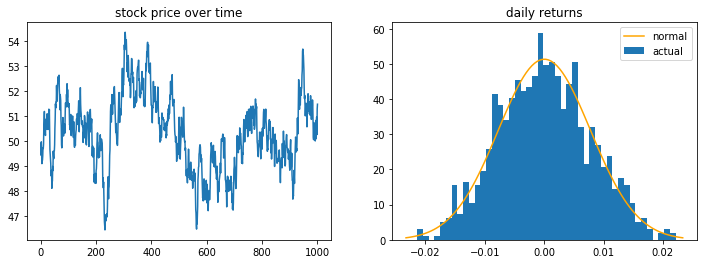

In [7]:
# ---------- Run simulation - no cluster building ---------- #
# input parameters
n_traders = 500
initial_cash = 50_000.0
initial_num_stocks = 1_000
n_simulation_steps = 1_000
cluster_building = False
induce_imbalance = False

# run simulation:
traders = []
for i in range(n_traders):
    if i < n_traders / 2:
        traders.append(Trader(i + 1, initial_cash, initial_num_stocks, tendency='opt'))
    else:
        traders.append(Trader(i + 1, initial_cash, initial_num_stocks, tendency='pes'))
clearing_prices, cluster_buy, cluster_sell = simulation(traders, number_of_steps=n_simulation_steps, 
    cluster_building=cluster_building)
# evaluate results:
log_returns = get_log_returns(clearing_prices)
plot_results(log_returns, 'no clusters')

100.0%
simulation with 1000 steps completed in 681.081 seconds
results clustering method


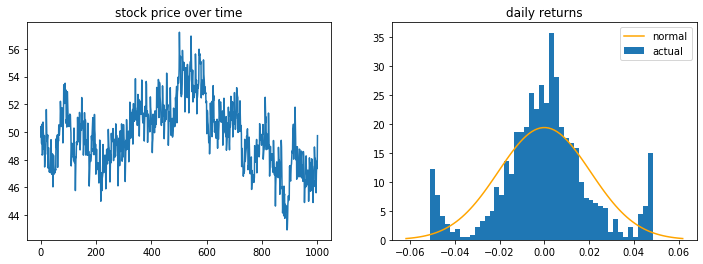

In [9]:
# ---------- Run simulation - with cluster building ---------- #
# input parameters
n_traders = 500
initial_cash = 50_000.0
initial_num_stocks = 1_000
n_simulation_steps = 1_000
cluster_building = True
induce_imbalance = False
p_a = 0.005
p_c = 0.1

# run simulation:
traders = []
for i in range(n_traders):
    if i < n_traders / 2:
        traders.append(Trader(i + 1, initial_cash, initial_num_stocks, tendency='opt'))
    else:
        traders.append(Trader(i + 1, initial_cash, initial_num_stocks, tendency='pes'))
clearing_prices, cluster_buy, cluster_sell = simulation(traders, number_of_steps=n_simulation_steps, 
    cluster_building=cluster_building, p_a=p_a,  p_c=p_c)
# evaluate results:
log_returns_cluster = get_log_returns(clearing_prices)
plot_results(log_returns_cluster, 'clustering method')

100.0%
simulation with 1000 steps completed in 26.593 seconds
results induced imbalance


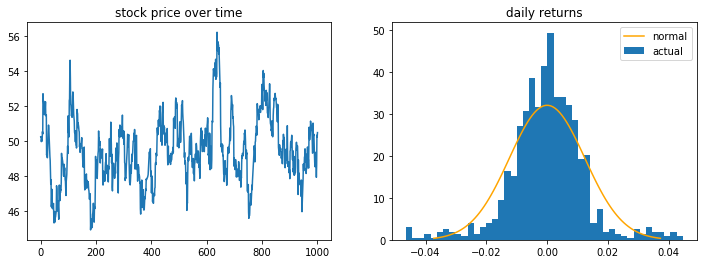

In [10]:
# ---------- Run simulation - with induced imbalance ---------- #
# input parameters
n_traders = 500
initial_cash = 50_000.0
initial_num_stocks = 1_000
n_simulation_steps = 1_000
cluster_building = False
induce_imbalance = True
p_imbalance = 0.15

# run simulation:
traders = []
for i in range(n_traders):
    if i < n_traders / 2:
        traders.append(Trader(i + 1, initial_cash, initial_num_stocks, tendency='opt'))
    else:
        traders.append(Trader(i + 1, initial_cash, initial_num_stocks, tendency='pes'))
clearing_prices, cluster_buy, cluster_sell = simulation(traders, number_of_steps=n_simulation_steps, 
    cluster_building=cluster_building, induce_imbalance=induce_imbalance, p_imbalance=p_imbalance)
# evaluate results:
log_returns_imb = get_log_returns(clearing_prices)
plot_results(log_returns_imb, 'induced imbalance')

#### 3. Compare results to real world data
Compare the results to actual distribution (daily returns from S&P 500 since 1927). Divided into chunks of 1,000 daily returns (to match the number of steps in one simulation)

In [11]:
def compare_distributions(dist1, dist2, name_dist1, name_dist2):
    ks = stats.ks_2samp(dist1, dist2)
    print(f'Simulation method {name_dist1}:')
    print(f'Results Kolmogorov-Smirnov: statistic = {ks[0]}, P_value = {ks[1]}')
    dist1_sorted = np.sort(dist1)
    dist2_sorted = np.sort(dist2)
    p_dist1 = 1. * np.arange(len(dist1)) / (len(dist1) - 1)
    p_dist2 = 1. * np.arange(len(dist2)) / (len(dist2) - 1)
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.hist(dist1,bins=50, density=True, alpha=0.5)
    plt.hist(dist2,bins=50, density=True, alpha=0.5, color='orange')
    plt.legend([name_dist1, name_dist2])
    plt.subplot(1, 2, 2)
    plt.plot(dist1_sorted, p_dist1)
    plt.plot(dist2_sorted, p_dist2, color='orange')
    plt.legend([name_dist1, name_dist2])
    plt.show()

In [12]:
# ---------- load S&P data ---------- #
df_s_and_p = pd.read_csv('data/GSPC.csv')
s_and_p_log_returns = get_log_returns(df_s_and_p['Close'])
s_and_p_chunks = []
for i in range(int(df_s_and_p.shape[0] / 1000)):
    s_and_p_chunks.append(s_and_p_log_returns[i*1000:(i+1)*1000])

Example of comparison between simulated and real returns for an S&P sequence with fat tails (simulated returns with metods to increase probability of especially low and high returns fit best):

Simulation method regular:
Results Kolmogorov-Smirnov: statistic = 0.155, P_value = 6.763913130197589e-11


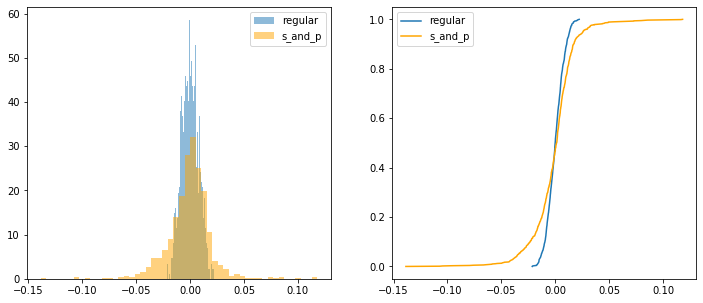

Simulation method with clusters:
Results Kolmogorov-Smirnov: statistic = 0.057, P_value = 0.07761108123267829


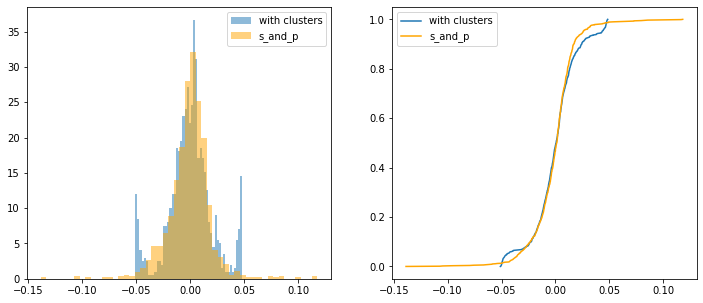

Simulation method with imbalance:
Results Kolmogorov-Smirnov: statistic = 0.103, P_value = 4.872295384883887e-05


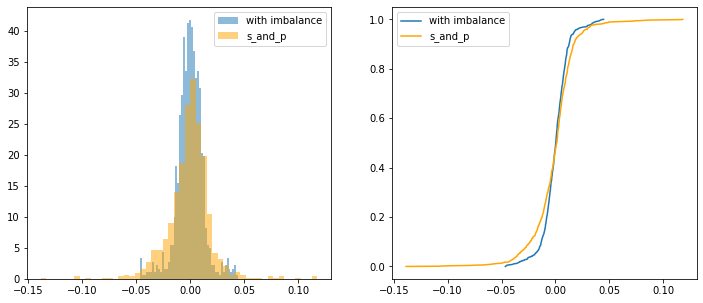

In [13]:
# ---------- example 1: S&P with fat tails ---------- #
i = 0
compare_distributions(log_returns, s_and_p_chunks[i], 'regular', 's_and_p')
compare_distributions(log_returns_cluster, s_and_p_chunks[i], 'with clusters', 's_and_p')
compare_distributions(log_returns_imb, s_and_p_chunks[i], 'with imbalance', 's_and_p')

Example of comparison between simulated and real returns for an S&P sequence without fat tails (normally distributed returns fit best).

Simulation method regular:
Results Kolmogorov-Smirnov: statistic = 0.088, P_value = 0.0008613642727365059


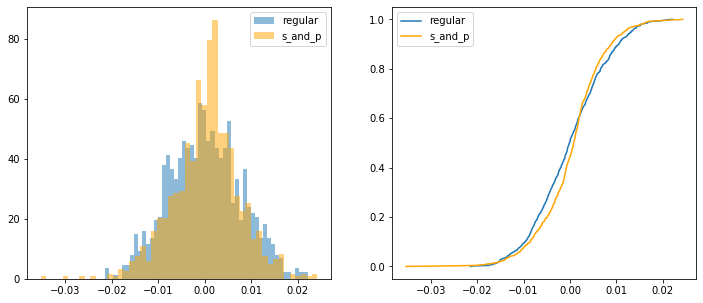

Simulation method with clusters:
Results Kolmogorov-Smirnov: statistic = 0.189, P_value = 5.032549473768586e-16


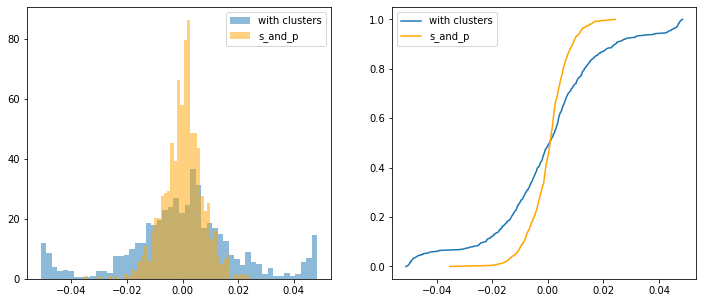

Simulation method with imbalance:
Results Kolmogorov-Smirnov: statistic = 0.112, P_value = 6.990901300156074e-06


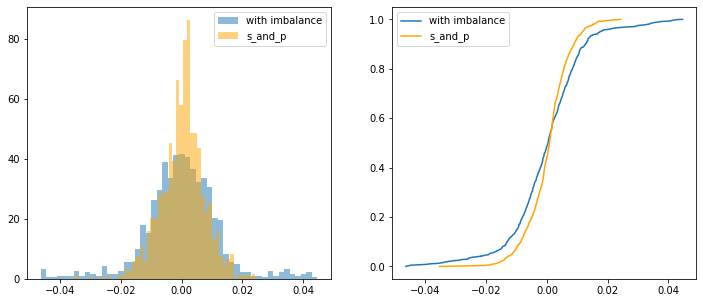

In [14]:
# ---------- example 2: S&P without fat tails ---------- #
i = 19
compare_distributions(log_returns, s_and_p_chunks[i], 'regular', 's_and_p')
compare_distributions(log_returns_cluster, s_and_p_chunks[i], 'with clusters', 's_and_p')
compare_distributions(log_returns_imb, s_and_p_chunks[i], 'with imbalance', 's_and_p')

Run each setting five times and compare each of the resulting log-return distributions to each of the S&P sequences. Calculate the average Kolmogorov-Smirnov: statistic

In [20]:
# ---------- run all simulations --------- #
n_runs_for_each = 5
n_traders = 500
initial_cash = 50_000.0
initial_num_stocks = 1_000
n_simulation_steps = 1_000
log_returns_regular_, log_returns_cluster_, log_returns_imb_ = [], [], []

# 1. regular
cluster_building = False
induce_imbalance = False
print('run simulations regular:')
for i in range(n_runs_for_each):
    traders = []
    for i in range(n_traders):
        traders.append(Trader(i + 1, initial_cash, initial_num_stocks))
    prices, _, _ = simulation(traders, number_of_steps=n_simulation_steps, 
        cluster_building=cluster_building, induce_imbalance=induce_imbalance)
    log_returns_regular_.append(get_log_returns(prices))

# with cluster
cluster_building = True
induce_imbalance = False
print('\nrun simulations with clusters:')
p_a = 0.005
p_c = 0.1
for i in range(n_runs_for_each):
    traders = []
    for i in range(n_traders):
        if i < n_traders / 2:
            traders.append(Trader(i + 1, initial_cash, initial_num_stocks, tendency='opt'))
        else:
            traders.append(Trader(i + 1, initial_cash, initial_num_stocks, tendency='pes'))
    prices, _, _ = simulation(traders, number_of_steps=n_simulation_steps, 
        cluster_building=cluster_building, p_a=p_a,  p_c=p_c, induce_imbalance=induce_imbalance)
    log_returns_cluster_.append(get_log_returns(prices))

# with buy/sell imbalance
cluster_building = False
induce_imbalance = True
p_imbalance = 0.15
print('\nrun simulations with imbalance:')
for i in range(n_runs_for_each):
    traders = []
    for i in range(n_traders):
        traders.append(Trader(i + 1, initial_cash, initial_num_stocks))
    prices, _, _ = simulation(traders, number_of_steps=n_simulation_steps, 
        cluster_building=cluster_building, induce_imbalance=induce_imbalance, p_imbalance=p_imbalance)
    log_returns_imb_.append(get_log_returns(prices))

run simulations regular:
100.0%
simulation with 1000 steps completed in 23.507 seconds
100.0%
simulation with 1000 steps completed in 23.788 seconds
100.0%
simulation with 1000 steps completed in 23.608 seconds
100.0%
simulation with 1000 steps completed in 23.59 seconds
100.0%
simulation with 1000 steps completed in 23.687 seconds

run simulations with clusters:
100.0%
simulation with 1000 steps completed in 565.406 seconds
100.0%
simulation with 1000 steps completed in 559.648 seconds
100.0%
simulation with 1000 steps completed in 564.11 seconds
100.0%
simulation with 1000 steps completed in 570.402 seconds
100.0%
simulation with 1000 steps completed in 560.316 seconds

run simulations with imbalance:
100.0%
simulation with 1000 steps completed in 24.424 seconds
100.0%
simulation with 1000 steps completed in 22.678 seconds
100.0%
simulation with 1000 steps completed in 22.715 seconds
100.0%
simulation with 1000 steps completed in 22.676 seconds
100.0%
simulation with 1000 steps compl

In [21]:
# ---------- evaluate results --------- #
stats_regular, stats_cluster, stats_imb = [], [], []
for i in range(len(s_and_p_chunks)):
    for j in range(n_runs_for_each):
        stats_r, _ = stats.ks_2samp(log_returns_regular_[j], s_and_p_chunks[i])
        stats_c, _ = stats.ks_2samp(log_returns_cluster_[j], s_and_p_chunks[i])
        stats_i, _ = stats.ks_2samp(log_returns_imb_[j], s_and_p_chunks[i])
        stats_regular.append(stats_r)
        stats_cluster.append(stats_c)
        stats_imb.append(stats_i)
print('mean stats regular:', np.mean(stats_regular), 'std stats regular: ', np.std(stats_regular))
print('mean stats cluster:', np.mean(stats_cluster), 'std stats cluster: ', np.std(stats_cluster))
print('mean stats imbalance:', np.mean(stats_imb), 'std stats imbalance: ', np.std(stats_imb))

mean stats regular: 0.09780869565217391 std stats regular:  0.04166760719795444
mean stats cluster: 0.16273043478260868 std stats cluster:  0.05993885605371824
mean stats imbalance: 0.10050434782608697 std stats imbalance:  0.03715733268684333
